In [10]:
import os
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from urllib.request import urlretrieve
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.utils import plot_model

In [3]:
df = pd.read_excel(r"C:\Users\Aniketha Prasad\Downloads\istanbul+stock+exchange\data_akbilgic.xlsx",skiprows=1)
df.head()

C:\Users\Aniketha Prasad\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,date,ISE,ISE.1,SP,DAX,FTSE,NIKKEI,BOVESPA,EU,EM
0,2009-01-05,0.035754,0.038376,-0.004679,0.002193,0.003894,0.000000,0.031190,0.012698,0.028524
1,2009-01-06,0.025426,0.031813,0.007787,0.008455,0.012866,0.004162,0.018920,0.011341,0.008773
2,2009-01-07,-0.028862,-0.026353,-0.030469,-0.017833,-0.028735,0.017293,-0.035899,-0.017073,-0.020015
3,2009-01-08,-0.062208,-0.084716,0.003391,-0.011726,-0.000466,-0.040061,0.028283,-0.005561,-0.019424
4,2009-01-09,0.009860,0.009658,-0.021533,-0.019873,-0.012710,-0.004474,-0.009764,-0.010989,-0.007802


In [4]:
def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i + seq_length])
        y_seq.append(y[i + seq_length])
    return np.array(X_seq), np.array(y_seq)

In [6]:
for col in df.select_dtypes(include=['datetime64']):
    df[col] = df[col].astype('int64') // 10**9

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(df.iloc[:, :-1])  # Features
y_scaled = scaler_y.fit_transform(df.iloc[:, -1].values.reshape(-1, 1))  # Target

In [7]:
sequence_length = 7  # One week lookback period
train_size = int(len(X_scaled) * 0.8)

X_train_data = X_scaled[:train_size]
X_test_data = X_scaled[train_size - sequence_length:]
y_train_data = y_scaled[:train_size]
y_test_data = y_scaled[train_size - sequence_length:]

# Create sequences
X_train, y_train = create_sequences(X_train_data, y_train_data, sequence_length)
X_test, y_test = create_sequences(X_test_data, y_test_data, sequence_length)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (421, 7, 9)
Testing data shape: (108, 7, 9)


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Scale features and target
scaler_X, scaler_y = MinMaxScaler(), MinMaxScaler()
X_scaled = scaler_X.fit_transform(df.iloc[:, :-1])
y_scaled = scaler_y.fit_transform(df.iloc[:, -1].values.reshape(-1, 1))

# Create sequences
def create_sequences(data, target, seq_length):
    return np.array([data[i:i + seq_length] for i in range(len(data) - seq_length)]), \
           np.array([target[i + seq_length] for i in range(len(target) - seq_length)])

# Split data
seq_len, train_size = 7, int(len(X_scaled) * 0.8)
X_train, y_train = create_sequences(X_scaled[:train_size], y_scaled[:train_size], seq_len)
X_test, y_test = create_sequences(X_scaled[train_size - seq_len:], y_scaled[train_size - seq_len:], seq_len)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")


In [8]:
# Function to build LSTM model
def build_lstm_model(sequence_length, n_features):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(sequence_length, n_features), recurrent_dropout=0.1),
        LSTM(64, return_sequences=True, recurrent_dropout=0.1),
        LSTM(64, recurrent_dropout=0.1),
        Dropout(0.2),
        Dense(1)
    ])
    
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    print(model.summary())
    
    return model

In [11]:
# Build the model
model = build_lstm_model(sequence_length, X_train.shape[2])

# Plot model architecture
plot_model(model, to_file='lstm_model.png', show_shapes=True, show_layer_names=True, rankdir='LR')

# Define callbacks
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                      │ (None, 7, 64)                 │      18,944 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ lstm_4 (LSTM)                      │ (None, 7, 64)                 │      33,024 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ lstm_5 (LSTM)                      │ (None, 64)                    │      33,024 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dropout_1 (Dropout)                │ (None, 64)                    │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_1 (Dense)                    │ (None, 1)                     │          65 │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 85,057 (332.25 KB)

 Trainable params: 85,057 (332.25 KB)

 Non-trainable params: 0 (0.00 B)

None


In [12]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stop, lr_scheduler],
    verbose=1
)

Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.1092 - val_loss: 0.0194 - learning_rate: 0.0010
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0214 - val_loss: 0.0148 - learning_rate: 0.0010
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0200 - val_loss: 0.0139 - learning_rate: 0.0010
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0194 - val_loss: 0.0138 - learning_rate: 0.0010
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0176 - val_loss: 0.0138 - learning_rate: 0.0010
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0183 - val_loss: 0.0141 - learning_rate: 0.0010
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0188 - val_loss: 0.0138 - learning_rate: 0.0010
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0186 - val_loss: 0.0154 - learning_rate: 0.0010
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0232 - val_loss: 0.0137 - learning_rate: 5.0000e-04
Epoch 10/100

In [13]:
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Invert predictions back to original scale
train_predictions = scaler_y.inverse_transform(train_predictions)
y_train_inv = scaler_y.inverse_transform(y_train)
test_predictions = scaler_y.inverse_transform(test_predictions)
y_test_inv = scaler_y.inverse_transform(y_test)

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [14]:
def calculate_metrics(actual, predicted):
    metrics = {
        'RMSE': math.sqrt(mean_squared_error(actual, predicted)),
        'MAE': mean_absolute_error(actual, predicted),
        'R²': r2_score(actual, predicted),
        'MAPE': np.mean(np.abs((actual - predicted) / (actual + 1e-5))) * 100
    }
    return metrics

# Calculate performance metrics
train_metrics = calculate_metrics(y_train_inv, train_predictions)
test_metrics = calculate_metrics(y_test_inv, test_predictions)

print("Training Metrics:", train_metrics)
print("Testing Metrics:", test_metrics)

Training Metrics: {'RMSE': 0.011293263803000955, 'MAE': 0.008364363410464738, 'R²': -0.02301988317393855, 'MAPE': 260.7056243894753}
Testing Metrics: {'RMSE': 0.006272805744828598, 'MAE': 0.0048283653682192305, 'R²': -0.03647140835564411, 'MAPE': 138.9771555972557}


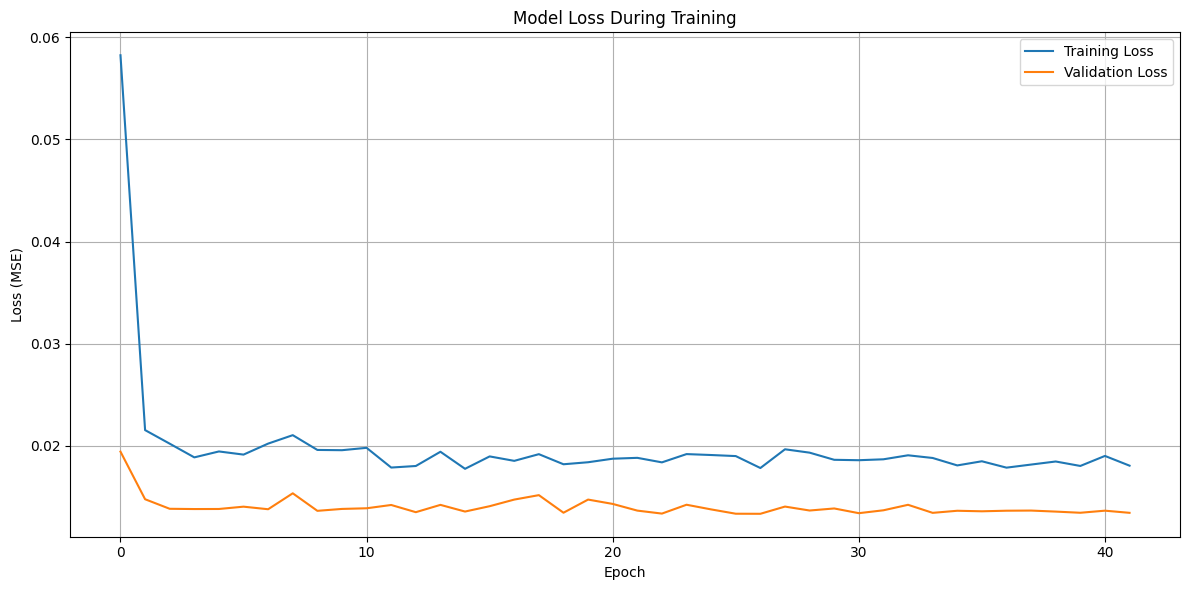

In [15]:
# Plot training loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.savefig('training_loss.png')
plt.show()

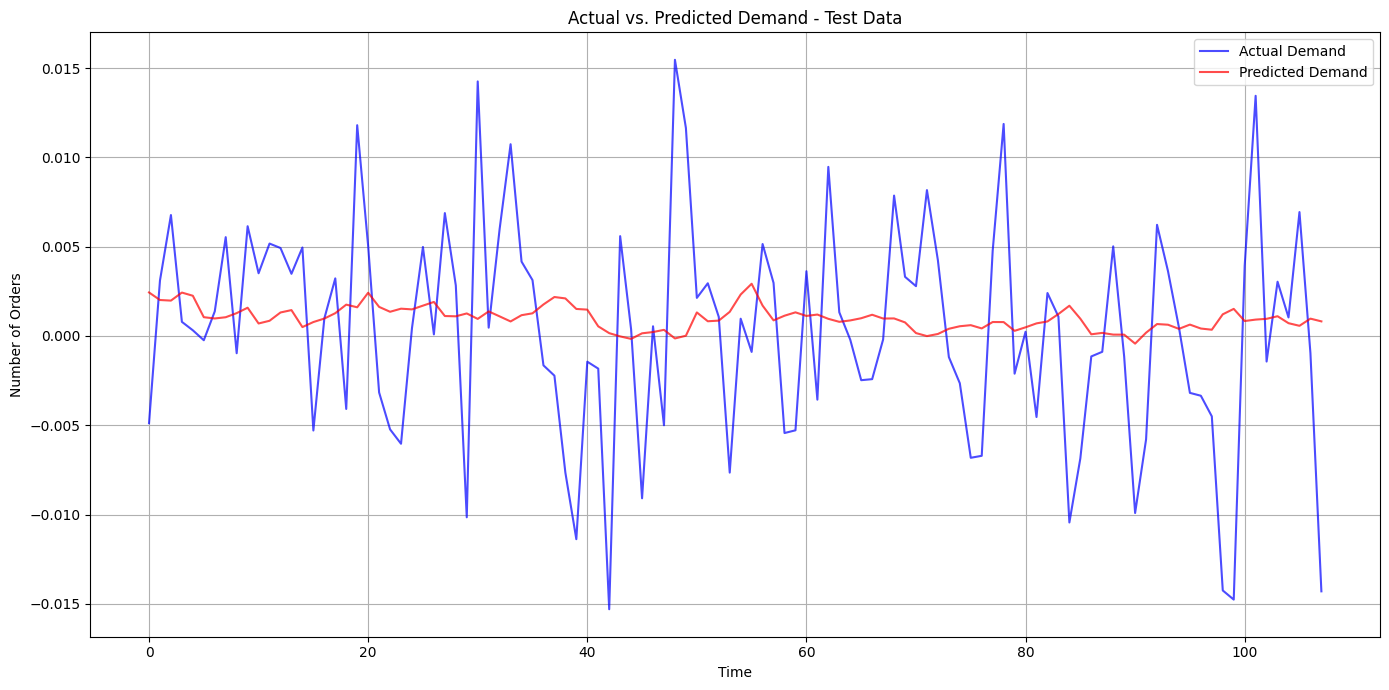

In [16]:
# Plot actual vs predicted on test data
plt.figure(figsize=(14, 7))
plt.plot(y_test_inv, label='Actual Demand', color='blue', alpha=0.7)
plt.plot(test_predictions, label='Predicted Demand', color='red', alpha=0.7)
plt.title('Actual vs. Predicted Demand - Test Data')
plt.ylabel('Number of Orders')
plt.xlabel('Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('test_predictions.png')
plt.show()

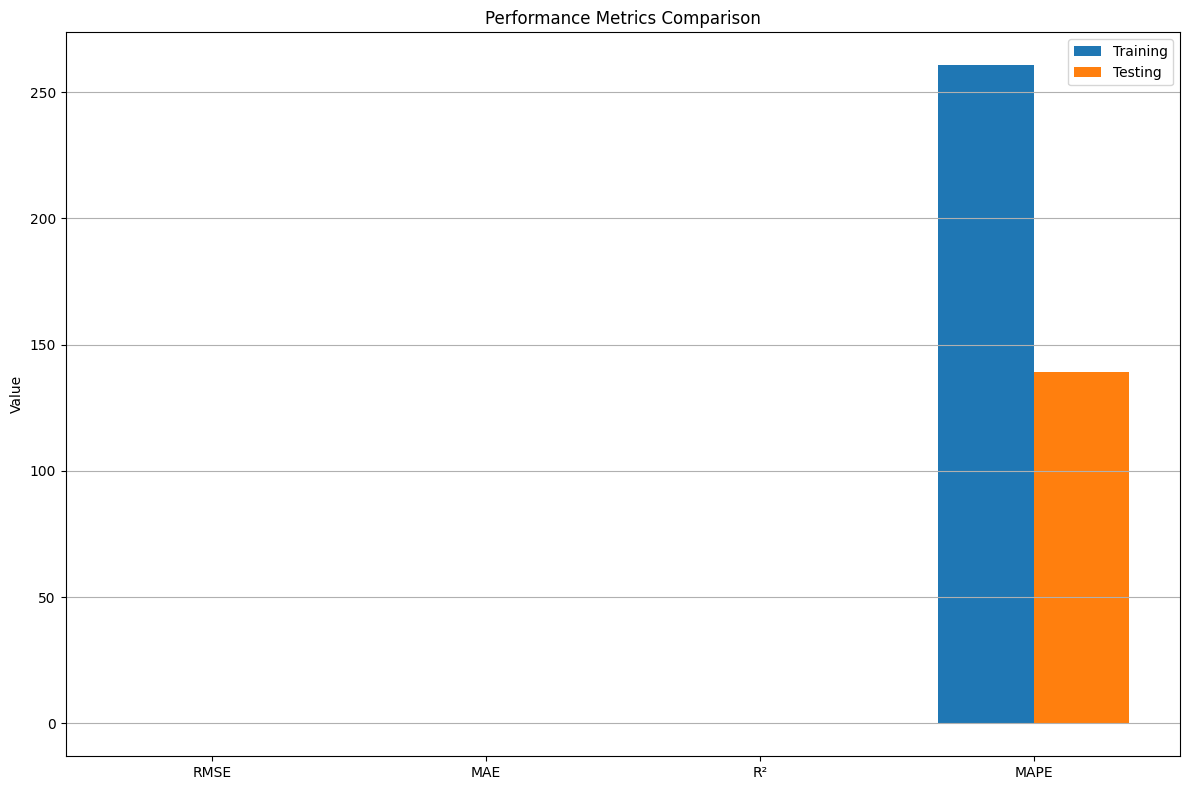

In [17]:
# Performance Metrics Visualization
metrics_names = list(train_metrics.keys())
train_values = [train_metrics[m] for m in metrics_names]
test_values = [test_metrics[m] for m in metrics_names]

plt.figure(figsize=(12, 8))
x = np.arange(len(metrics_names))
width = 0.35
plt.bar(x - width/2, train_values, width, label='Training')
plt.bar(x + width/2, test_values, width, label='Testing')
plt.title('Performance Metrics Comparison')
plt.xticks(x, metrics_names)
plt.ylabel('Value')
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.savefig('performance_metrics.png')
plt.show()